# 

## Install Python libraries
* To temporarily install Python libraries for server use, use the command: `%pip`.

In [1]:
%pip install simplekml
%pip install geopy
%pip install -U kaleido

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Python libraries

In [2]:
from sliderule import sliderule, icesat2, earthdata
import geopandas as gpd
import pandas as pd
import folium
import numpy as np
from shapely.geometry import Polygon, Point, mapping
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.linear_model import LinearRegression
import geopy
import simplekml
from geopy.distance import geodesic
from matplotlib.backends.backend_pdf import PdfPages
import plotly.express as px
from tqdm import tqdm
import warnings
from scipy.stats import linregress

In [3]:
segment_meter = "100"
cnt = "10"
ats = "10"

site_name = "BONA"
# site_name = "DEJU"
# site_name = "WREF"
# site_name = "RMNP"
# site_name = "TEAK"

year_folder = 'year/'
day_folder = 'day/'

In [4]:
def compile_dates_for_site(folder, site_name):
    """
    Reads all CSV files for the specified site in a folder, extracts the 'date' column,
    and compiles a unique list of dates.

    Args:
        folder (str): The directory containing the CSV files.

    Returns:
        list: A sorted list of unique dates for the specified site.
    """
    print(site_name)
    all_dates = set()  # Use a set to ensure unique dates

    # Iterate through all files in the folder
    for filename in os.listdir(folder):
        if filename.startswith(site_name) and filename.endswith(".csv"):  # Match site_name in the file name
            filepath = os.path.join(folder, filename)
            try:
                # Read the CSV file into a DataFrame
                df = pd.read_csv(filepath)
                if 'date' in df.columns and 'ground_photon_count' in df.columns and 'canopy_photon_count' in df.columns:
                    # Filter rows where both ground_photon_count and canopy_photon_count are 0
                    filtered_df = df[(df['ground_photon_count'] != 0) | (df['canopy_photon_count'] != 0)]
                    # Add unique dates directly from the 'date' column as strings
                    all_dates.update(filtered_df['date'].dropna().unique())
            except Exception as e:
                print(f"Error processing file {filename}: {e}")

    # Return sorted list of unique dates
    return sorted(all_dates)

site_dates = compile_dates_for_site(year_folder, site_name)
print(site_dates)

BONA
['2019-06-26', '2019-09-11', '2019-09-24', '2019-12-24', '2020-05-11', '2020-09-22', '2020-11-09', '2020-12-08', '2021-02-08', '2021-03-22', '2021-06-21', '2021-10-19', '2021-11-07', '2022-03-21', '2022-06-06', '2022-08-07', '2022-09-05', '2022-09-18', '2022-10-17', '2022-11-06', '2022-12-18', '2023-01-20', '2023-01-31', '2023-02-18', '2023-03-05', '2023-03-19', '2023-04-17', '2023-04-21', '2023-05-06', '2023-08-05', '2023-09-16', '2023-10-15', '2023-11-13']


In [5]:
def generate_date_time_ranges(dates):
    """
    Generate a dictionary of start and end times for each unique date.

    Args:
        dates (list of str): List of date strings in the format "YYYY-MM-DD".
        
    Returns:
        list of dict: A list of dictionaries where each dictionary represents a time range
                      with 'start_time' and 'end_time' for a specific date.
    """
    time_ranges = []
    for date in dates:
        start_time = f"{date}T00:00:00Z"
        end_time = f"{date}T23:59:59Z"
        
        # Append the date with its start_time and end_time to the time_ranges list
        time_ranges.append({
            "date": date, 
            "start_time": start_time, 
            "end_time": end_time
        })
    return time_ranges

site_time_ranges = generate_date_time_ranges(site_dates)
print(site_name)
for date in site_time_ranges:
    print(date)
print(len(site_time_ranges))

BONA
{'date': '2019-06-26', 'start_time': '2019-06-26T00:00:00Z', 'end_time': '2019-06-26T23:59:59Z'}
{'date': '2019-09-11', 'start_time': '2019-09-11T00:00:00Z', 'end_time': '2019-09-11T23:59:59Z'}
{'date': '2019-09-24', 'start_time': '2019-09-24T00:00:00Z', 'end_time': '2019-09-24T23:59:59Z'}
{'date': '2019-12-24', 'start_time': '2019-12-24T00:00:00Z', 'end_time': '2019-12-24T23:59:59Z'}
{'date': '2020-05-11', 'start_time': '2020-05-11T00:00:00Z', 'end_time': '2020-05-11T23:59:59Z'}
{'date': '2020-09-22', 'start_time': '2020-09-22T00:00:00Z', 'end_time': '2020-09-22T23:59:59Z'}
{'date': '2020-11-09', 'start_time': '2020-11-09T00:00:00Z', 'end_time': '2020-11-09T23:59:59Z'}
{'date': '2020-12-08', 'start_time': '2020-12-08T00:00:00Z', 'end_time': '2020-12-08T23:59:59Z'}
{'date': '2021-02-08', 'start_time': '2021-02-08T00:00:00Z', 'end_time': '2021-02-08T23:59:59Z'}
{'date': '2021-03-22', 'start_time': '2021-03-22T00:00:00Z', 'end_time': '2021-03-22T23:59:59Z'}
{'date': '2021-06-21', 's

In [6]:
%%time

def process_site(site, time_ranges):
    """
    Processes a site by requesting ATL03 data for specified time ranges.

    Args:
        region (dict): A dictionary containing the spatial region of interest, with a 'poly' key for the polygon.
        time_ranges (dict): A dictionary where keys are years, and values are dictionaries with 'start_time' and 'end_time'.
        cnt (int, optional): Number of photons required for the analysis. Defaults to None.
        ats (int, optional): Along-track spacing for the data. Defaults to None.
        segment_meter (float, optional): Segment length and resolution in meters. Defaults to 10.

    Returns:
        dict: A dictionary where keys are years, and values are the retrieved ATL03 data.
    """
    # Load the region dynamically based on the site
    region = sliderule.toregion(f"geojson_files/{site}_buffer_8km.geojson")
    
    # Dictionary to store ATL03 data for each year
    site_data = {}
    
    for time_range  in time_ranges:
        # Construct the parameters for the current time range
        parms = {
            "poly": region['poly'],       # Region polygon
            "t0": time_range['start_time'],   # Start time
            "t1": time_range['end_time'],     # End time
            "srt": icesat2.SRT_LAND,           # Surface return type
            "cnf": 2,                    # Confidence level (2 is low-confidence)
            "cnt": cnt,                  # Number of photons
            "ats": ats,                  # Along-track spacing
            "len": segment_meter,        # Segment length
            "res": segment_meter,        # Resolution
            "atl08_class": [             # ATL08 classifications
                "atl08_noise",
                "atl08_ground",
                "atl08_canopy",
                "atl08_top_of_canopy",
                "atl08_unclassified"
            ],
            "phoreal": {                 # Phoreal processing settings
                "binsize": 1.0,
                "geoloc": "mean",
                "use_abs_h": True,
                "send_waveform": True
            }
        }

        # Request the ATL03 data using icesat2
        atl03_data = icesat2.atl03sp(parms, keep_id=True)

        columns_to_drop = [
        'region', 'pair', 'segment_dist', 'segment_id', 'cycle', 'track', 'background_rate', 'y_atc', 'x_atc', 
            'yapc_score', 'atl03_cnf', 'relief', 'quality_ph'
        ]
        
        # Drop the columns from the DataFrame
        atl03_data = atl03_data.drop(columns=columns_to_drop)
        
        # Use the date as the key for storing data
        site_data[time_range['date']] = atl03_data

    return site_data

site_data = process_site(site_name, site_time_ranges)

CPU times: user 41.1 s, sys: 933 ms, total: 42.1 s
Wall time: 2min


In [7]:
# Loop through the site_data dictionary

print (len(site_data))
for date, site_datum in site_data.items():
    print(f"Date: {date}")
    print("Columns:", site_datum.columns.tolist())  # Print the list of column names

33
Date: 2019-06-26
Columns: ['extent_id', 'rgt', 'solar_elevation', 'sc_orient', 'atl08_class', 'snowcover', 'height', 'landcover', 'geometry', 'spot']
Date: 2019-09-11
Columns: ['extent_id', 'rgt', 'solar_elevation', 'sc_orient', 'atl08_class', 'snowcover', 'height', 'landcover', 'geometry', 'spot']
Date: 2019-09-24
Columns: ['extent_id', 'rgt', 'solar_elevation', 'sc_orient', 'atl08_class', 'snowcover', 'height', 'landcover', 'geometry', 'spot']
Date: 2019-12-24
Columns: ['extent_id', 'rgt', 'solar_elevation', 'sc_orient', 'atl08_class', 'snowcover', 'height', 'landcover', 'geometry', 'spot']
Date: 2020-05-11
Columns: ['extent_id', 'rgt', 'solar_elevation', 'sc_orient', 'atl08_class', 'snowcover', 'height', 'landcover', 'geometry', 'spot']
Date: 2020-09-22
Columns: ['extent_id', 'rgt', 'solar_elevation', 'sc_orient', 'atl08_class', 'snowcover', 'height', 'landcover', 'geometry', 'spot']
Date: 2020-11-09
Columns: ['extent_id', 'rgt', 'solar_elevation', 'sc_orient', 'atl08_class', 'sn

In [8]:
%%time
def process_photons(site_data):
    """
    Processes site data to calculate canopy and terrain photon rates for each segment and checks for duplicate times.

    Args:
        site_data (dict): A dictionary where each value is a DataFrame containing data for a site.

    Returns:
        dict: A dictionary with the same keys as `site_data`, containing processed DataFrames.
    """
    processed_data = {}

    for date, data in site_data.items():
        # Ensure 'time' is the index and in datetime format
        data.index = pd.to_datetime(data.index)

        # Extract latitude and longitude from the 'geometry' column
        data['latitude'] = data['geometry'].apply(lambda x: x.y if x else None)
        data['longitude'] = data['geometry'].apply(lambda x: x.x if x else None)

        # Separate photons into canopy and terrain classes
        canopy_photons = data[data['atl08_class'].isin([2, 3])]  # Classes 2 and 3 for canopy
        terrain_photons = data[data['atl08_class'] == 1]         # Class 1 for ground

        # Count photons for each segment
        canopy_counts = canopy_photons.groupby('extent_id').size().reset_index(name='canopy_photon_count')
        terrain_counts = terrain_photons.groupby('extent_id').size().reset_index(name='terrain_photon_count')

        # Convert the index to a column temporarily
        data['time_index'] = data.index
        
        # Group by 'extent_id' and count unique 'time_index' values (representing unique times)
        unique_time_count = (
            data.groupby('extent_id')['time_index']
            .nunique()
            .reset_index(name='unique_shots')
        )
        
        # Drop the temporary 'time_index' column
        data = data.drop(columns='time_index')

        # Merge canopy and terrain counts into one DataFrame
        segment_counts = (
            canopy_counts
            .merge(terrain_counts, on='extent_id', how='outer')
            .merge(unique_time_count, on='extent_id', how='outer')
        )

        # Replace any zero or NaN values in 'unique_shots' with NaN to avoid division by zero errors
        segment_counts['unique_shots'] = segment_counts['unique_shots'].replace(0, np.nan)

        # Calculate photon rates by normalizing with the number of unique shots
        segment_counts['canopy_photon_rate'] = segment_counts['canopy_photon_count'] / segment_counts['unique_shots']
        segment_counts['terrain_photon_rate'] = segment_counts['terrain_photon_count'] / segment_counts['unique_shots']

        # Reset index to keep 'time' as a column for merging
        data = data.reset_index()

        # Merge photon rates into the main DataFrame
        data = data.merge(
            segment_counts[['extent_id', 'canopy_photon_rate', 'terrain_photon_rate']], 
            on='extent_id', how='left'
        )

        # Check for duplicates in the 'time' column
        duplicate_times = data[data.index.duplicated()]

        # Log duplicates if needed (optional)
        if not duplicate_times.empty:
            print(f"date {date}: Found duplicate times in the 'time' column.")

        # Store processed data
        processed_data[date] = data

    return processed_data

processed_site_data = process_photons(site_data)

CPU times: user 50.9 s, sys: 549 ms, total: 51.5 s
Wall time: 50.9 s


In [9]:
# # Adjust display options
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.width', None)        # Use full width of the terminal
# pd.set_option('display.expand_frame_repr', False)  # Avoid column wrapping

# # Group by 'extent_id' and 'spot', then get the first row for each unique combination
# unique_spot_rows = processed_site_data["2023-04-21"].drop_duplicates(subset=['extent_id', 'spot'])

# # Display the result
# print(len(unique_spot_rows))
# # unique_spot_rows.head(50)
# print(unique_spot_rows.head())
# del unique_spot_rows

In [10]:
%%time
def add_landcover_and_date_info(processed_site_data):
    """
    Adds landcover mode and date-related columns (month, year, day) to each site DataFrame in processed_site_data.

    Args:
        processed_site_data (dict): A dictionary where each value is a DataFrame containing data for a site.

    Returns:
        dict: A dictionary with the same keys as `processed_site_data`, containing updated DataFrames.
    """
    valid_landcover_codes = {111, 113, 112, 114, 115, 116, 121, 123, 122, 124, 125, 126, 20}

    updated_data = {}

    for date, data in processed_site_data.items():
        # Step 1: Ensure there are no invalid landcover values before grouping
        valid_landcover_data = data[data["landcover"].isin(valid_landcover_codes)].copy()

        # Step 2: Calculate the landcover mode for each extent_id
        landcover_modes = valid_landcover_data.groupby("extent_id")["landcover"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

        # Step 3: Assign the calculated mode back to the original DataFrame
        data["landcover_mode"] = data["extent_id"].map(landcover_modes)

        # Step 4: Set 'time' back as the index if not already
        if "time" in data.columns:
            data.set_index("time", inplace=True)
            data.index = pd.to_datetime(data.index)

        # Step 5: Extract month, year, and day for aggregation
        data["month"] = data.index.month
        data["year"] = data.index.year
        data["day"] = data.index.day

        # Store the updated DataFrame in the dictionary
        updated_data[date] = data

    return updated_data

processed_site_data = add_landcover_and_date_info(processed_site_data)

CPU times: user 1.83 s, sys: 88.2 ms, total: 1.92 s
Wall time: 1.92 s


In [11]:
# # Adjust display options
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.width', None)        # Use full width of the terminal
# pd.set_option('display.expand_frame_repr', False)  # Avoid column wrapping

# # Group by 'extent_id' and 'spot', then get the first row for each unique combination
# unique_spot_rows = processed_site_data["2019-09-11"].drop_duplicates(subset=['extent_id', 'spot'])

# # Display the result
# print(len(unique_spot_rows))
# # unique_spot_rows.head(50)
# print(unique_spot_rows.head(50))
# del unique_spot_rows

In [12]:
def count_solar_elevation_values(processed_site_data):
    """
    Counts how many entries have positive or 0 values and how many have negative values in the solar_elevation column.

    Args:
        processed_site_data (dict): A dictionary where each value is a DataFrame containing processed site data.

    Returns:
        dict: A dictionary with the same keys as `processed_site_data`, containing the counts for positive/zero and negative values.
    """
    elevation_counts = {}

    for date, data in processed_site_data.items():
        # Ensure the 'solar_elevation' column exists
        if 'solar_elevation' in data.columns:
            # Count positive or 0 values
            positive_or_zero_count = (data['solar_elevation'] >= 0).sum()

            # Count negative values
            negative_count = (data['solar_elevation'] < 0).sum()

            # Store counts in the dictionary
            elevation_counts[date] = {
                "daytime": positive_or_zero_count,
                "nighttime": negative_count
            }
        else:
            print(f"Warning: 'solar_elevation' column not found for {date}. Skipping.")
            elevation_counts[date] = {"positive_or_zero": 0, "negative": 0}

    return elevation_counts

# Example usage:
solar_elev_counts = count_solar_elevation_values(processed_site_data)

for date, counts in solar_elev_counts.items():
    print(f"date: {date}, Daytime_photon_count: {counts['daytime']}, Nighttime_photon_count: {counts['nighttime']}")

date: 2019-06-26, Daytime_photon_count: 2722, Nighttime_photon_count: 0
date: 2019-09-11, Daytime_photon_count: 0, Nighttime_photon_count: 19518
date: 2019-09-24, Daytime_photon_count: 13539, Nighttime_photon_count: 0
date: 2019-12-24, Daytime_photon_count: 0, Nighttime_photon_count: 183736
date: 2020-05-11, Daytime_photon_count: 46491, Nighttime_photon_count: 0
date: 2020-09-22, Daytime_photon_count: 0, Nighttime_photon_count: 33600
date: 2020-11-09, Daytime_photon_count: 0, Nighttime_photon_count: 106
date: 2020-12-08, Daytime_photon_count: 0, Nighttime_photon_count: 1802
date: 2021-02-08, Daytime_photon_count: 0, Nighttime_photon_count: 189033
date: 2021-03-22, Daytime_photon_count: 175208, Nighttime_photon_count: 0
date: 2021-06-21, Daytime_photon_count: 11273, Nighttime_photon_count: 0
date: 2021-10-19, Daytime_photon_count: 0, Nighttime_photon_count: 70366
date: 2021-11-07, Daytime_photon_count: 3194, Nighttime_photon_count: 0
date: 2022-03-21, Daytime_photon_count: 175479, Night

In [13]:
%%time
def plot_all_sites_photon(processed_site_data, folder, site_name):
    """
    Plots photon rates for all dates and beam types (strong and weak) for a given site.
    
    Args:
        processed_site_data (dict): The processed data for each site (with date as the key).
        folder (str): The folder where the plot should be saved.
        site_name (str): The name of the site for naming the plot file.

    Returns:
        None
    """

    regression_results = {}
    
    # Loop through each date in the processed site data
    for date, data in processed_site_data.items():
        for beam_type in ['strong', 'weak']:
            # Convert the 'date' argument into a datetime object
            target_date = pd.to_datetime(date).date()
        
            # Construct the date from 'year', 'month', and 'day' columns in the data
            data['constructed_date'] = pd.to_datetime(data[['year', 'month', 'day']])
            
            # Filter data based on the beam type
            beam_filter = data['spot'].isin([1, 3, 5]) if beam_type == 'strong' else data['spot'].isin([2, 4, 6])
            # Filter the data for the specific date and beam type
            filtered_data = data[(data['constructed_date'].dt.date == target_date) & beam_filter]
            # Additional filtering to remove rows with NaN in 'canopy_photon_rate' or 'terrain_photon_rate'
            filtered_data = filtered_data.dropna(subset=['canopy_photon_rate', 'terrain_photon_rate'])
            
            # Check if the filtered data has entries
            if filtered_data.empty:
                print(f"No data available for {target_date} with {beam_type} beams.")
                continue

            # Create a scatter plot for photon rates
            fig, ax = plt.subplots(figsize=(10, 6))

            # Scatter plot of photon rates
            ax.scatter(
                filtered_data['terrain_photon_rate'],
                filtered_data['canopy_photon_rate'],
                label=f'{beam_type.capitalize()} Beams - {date}',
                alpha=0.6,
                edgecolor='w',
                s=50
            )

            # Perform linear regression on the scatter data
            slope, intercept, r_value, p_value, std_err = linregress(filtered_data['terrain_photon_rate'], 
                                                                      filtered_data['canopy_photon_rate'])
            
            # Create a line for the regression
            regression_line = slope * filtered_data['terrain_photon_rate'] + intercept

            # Plot the regression line
            ax.plot(filtered_data['terrain_photon_rate'], regression_line, color='red', label='Regression Line')

            # Adjust font size for the labels and title
            ax.set_xlabel('Terrain Photon Rate', fontsize=25)
            ax.set_ylabel('Canopy Photon Rate', fontsize=25)
            ax.set_title(f'{beam_type.capitalize()} Beams - {date}', fontsize=30)

            # Set the same x and y limits
            ax.set_xlim(0, 8)
            ax.set_ylim(0, 8)

            # Add legend with adjusted font size
            ax.legend(fontsize=20)

            save_folder = os.path.join(folder, site_name)
            os.makedirs(save_folder, exist_ok=True)

            # Save the individual plot as a PNG file
            savefile = os.path.join(save_folder, f'{site_name}_{date}_{beam_type}.png')
            plt.savefig(savefile, bbox_inches='tight', dpi=300)
            plt.close()
            plt.show()

            # Save the regression results (slope and intercept) in the dictionary
            regression_results[(date, beam_type)] = {'slope': slope, 'intercept': intercept}

            print(f"Plot saved as {savefile}")

    return regression_results

regression_results = plot_all_sites_photon(processed_site_data, day_folder, site_name)

Plot saved as day/BONA/BONA_2019-06-26_strong.png
No data available for 2019-06-26 with weak beams.
Plot saved as day/BONA/BONA_2019-09-11_strong.png
Plot saved as day/BONA/BONA_2019-09-11_weak.png
Plot saved as day/BONA/BONA_2019-09-24_strong.png
Plot saved as day/BONA/BONA_2019-09-24_weak.png
Plot saved as day/BONA/BONA_2019-12-24_strong.png
Plot saved as day/BONA/BONA_2019-12-24_weak.png
Plot saved as day/BONA/BONA_2020-05-11_strong.png
Plot saved as day/BONA/BONA_2020-05-11_weak.png
Plot saved as day/BONA/BONA_2020-09-22_strong.png
Plot saved as day/BONA/BONA_2020-09-22_weak.png
Plot saved as day/BONA/BONA_2020-11-09_strong.png
No data available for 2020-11-09 with weak beams.
Plot saved as day/BONA/BONA_2020-12-08_strong.png
No data available for 2020-12-08 with weak beams.
Plot saved as day/BONA/BONA_2021-02-08_strong.png
Plot saved as day/BONA/BONA_2021-02-08_weak.png
Plot saved as day/BONA/BONA_2021-03-22_strong.png
Plot saved as day/BONA/BONA_2021-03-22_weak.png
Plot saved as 

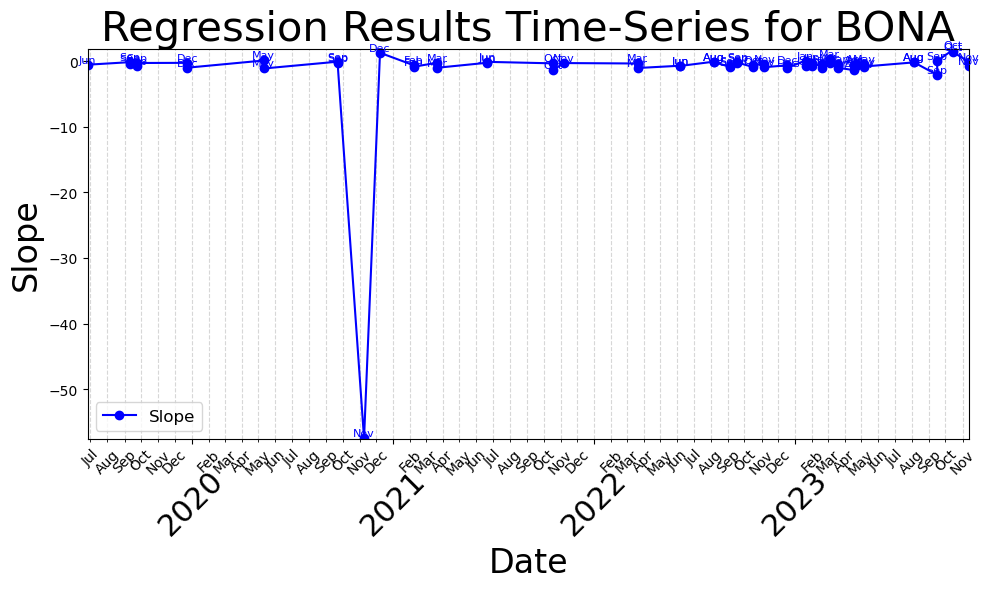

In [14]:
def plot_regression_time_series(regression_results, site_name, folder):
    """
    Plots a time-series of regression results (slope) by year, 
    with months labeled where data is available.
    
    Args:
        regression_results (dict): A dictionary with (date, beam_type) as keys, and regression results (slope and intercept) as values.
        site_name (str): The name of the site for naming the plot.
        folder (str): The folder where the plot should be saved.
    
    Returns:
        None
    """
    
    # Prepare data for the time-series plot
    dates = []
    slopes = []
    
    # Extract the date and slope from regression results
    for (date, beam_type), result in regression_results.items():
        # Add date and slope to respective lists
        dates.append(pd.to_datetime(date))  # Convert to datetime for easy handling
        slopes.append(result['slope'])
    
    # Create a DataFrame for easier handling
    df = pd.DataFrame({
        'date': dates,
        'slope': slopes,
    })
    
    # Set the date column as the index
    df.set_index('date', inplace=True)
    
    # Plot time-series for Slope
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot the slope
    ax.plot(df.index, df['slope'], label='Slope', color='b', marker='o')
    
    # Label months with data
    for i, (date, _) in enumerate(df.iterrows()):
        month_name = date.strftime('%b')  # Get the month abbreviation (e.g., 'Jan', 'Feb')
        ax.text(date, df.iloc[i]['slope'], month_name, fontsize=8, ha='center', va='bottom', color='blue')

    # Title and labels
    ax.set_title(f"Regression Results Time-Series for {site_name}", fontsize=30)
    ax.set_xlabel('Date', fontsize=24)
    ax.set_ylabel('Slope', fontsize=24)
    
    # Rotate the x-axis labels for clarity
    ax.tick_params(axis='x', rotation=45)
    
    # Major ticks for years
    major_ticks = pd.date_range(df.index.min(), df.index.max(), freq='YS')  # Annual start frequency
    ax.set_xticks(major_ticks)
    ax.set_xticklabels([x.strftime('%Y') for x in major_ticks])  # Year labels
    
    # Minor ticks for months
    minor_ticks = pd.date_range(df.index.min(), df.index.max(), freq='MS')  # Monthly start frequency
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_xticklabels([x.strftime('%b') for x in minor_ticks], minor=True)  # Month abbreviation labels
    ax.tick_params(axis='x', which='major', labelsize=22)  # Major tick label size
    ax.tick_params(axis='x', which='minor', labelsize=10, rotation=45)   # Minor tick label size and rotation

    # Adjust padding for the major tick labels (the year labels)
    ax.tick_params(axis='x', which='major', pad=15)  # Increase padding between year labels and x-axis
    
    # Set xlim and ylim to avoid unnecessary gaps
    ax.set_xlim([df.index.min(), df.index.max()])
    ax.set_ylim([df['slope'].min() - 0.1, df['slope'].max() + 0.1])  # Adding a small margin to y-limits
    
    # Enabling the minor grid and customizing the layout
    ax.grid(True, which='both', axis='x', linestyle='--', alpha=0.5)
    
    # Add legend
    ax.legend(fontsize=12)

    # Tight layout for proper spacing
    plt.tight_layout()

    # Save the plot to the specified folder
    savefile = os.path.join(folder, site_name, f'{site_name}_regression_time_series.png')
    plt.savefig(savefile, dpi=300)
    plt.show()

plot_regression_time_series(regression_results, site_name, day_folder)